<a href="https://colab.research.google.com/github/maxruther/Emotion-Recognition/blob/main/Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EMOTION RECOGNITION - FINAL PROJECT
## *Image Classification with CNN's*
### **by Max Ruther**

My final project for *CSC 578 (Neural Networks and Deep Learning)*.
<br></br>

## DATASET AND TASK

**Dataset URL:** https://www.kaggle.com/datasets/ameyamote030/einterface-image-dataset/code

With this dataset of frontal faces expressing one of six emotions, we intend to build an optimally accurate CNN classifier of the emotions depicted. The training set has 11,000+ image samples and the six labellings of emotion are anger, disgust, fear, happiness, neutral, and sadness.

## TABLE OF CONTENTS

- [Accessing the data](#setup-data)
- [Loading the data](#loading-data)
- [Visualizing several sample images](#visualizing-samples)
- [Modeling](#modeling)
  - [Hypertuning](#hypertuning)
- [Evaluating Models](#evaluating-models)
  - [Validation](#validation)
  - [Test](#test)
    - [Confusion Matrix](#confusion-matrix)
- [Conclusions](#conclusions)
- [Future Work](#future-work)
- [Challenges Faced: `ImageDataGenerator`](#challenges-faced)

## IMPORTS

In [1]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import zipfile
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import math
import time
import pickle

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# For hypertuning:
import keras_tuner as kt
from tensorflow import keras

<a name="setup-data"></a>
## DATA SETUP

#### Mount my Google Drive

Mounting my Google Drive, where I have uploaded a zip of the raw data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Unzip data to this Colab

Unzipping the data from my Google Drive to this Colab session.

In [4]:
with zipfile.ZipFile('drive/MyDrive/CSC_578/group_project/eINTERFACE_Image_Dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('the_image_data')

#### Unzip the models trained prior

The numerous models of this analysis often take 15 minutes or more to train. To cut down on time for this presentation, I load those already-trained models, as saved from that prior run.

The text feedback from those earlier trainings has been retained in this document, in the sections corresponding to those models.

In [5]:
# with zipfile.ZipFile('drive/MyDrive/CSC_578/group_project/Saved keras models and histories.zip', 'r') as zip_ref:
#   zip_ref.extractall('')

## UTILITY FUNCTIONS

A couple quick methods for pickling & unpickling

#### pickle_to_file

In [6]:
def pickle_to_file(history, filename):
  file = open(filename, 'wb')
  pickle.dump(history, file)

  return

#### unpickle_from_file

In [7]:
def unpickle_from_file(filename):
  file = open(filename, 'rb')
  history = pickle.load(file)
  file.close()

  return history

#### plot_history

From the class worksheet *exercise_flowers_with_data_augmentation_solution*, where it takes epochs as an argument in addition to history.

In [8]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

#### plot_confusion_matrix_heatmap

In [9]:
def plot_confusion_matrix_heatmap(conf_matrix, target_names):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='g', ax=ax)
  ax.set_xticklabels(target_names)
  ax.set_yticklabels(target_names, rotation=0)
  ax.set_title('Confusion Matrix Heatmap')
  plt.show()

<a name="loading-data"></a>
## DATA LOADING

### Generator Parameters

In [10]:
pixels = 128
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 256

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

### Creating Generators

In [11]:
base_dir = 'the_image_data/eINTERFACE_2021_Image'
train_dir = os.path.join(base_dir, 'train')
validate_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [13]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [14]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [15]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [16]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

In [17]:
print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [18]:
print(np.ceil(TRAIN_SIZE/BATCH_SIZE))
print(np.ceil(VAL_SIZE/BATCH_SIZE))
print(np.ceil(TEST_SIZE/BATCH_SIZE))

45.0
6.0
6.0


<a name="visualizing-samples"></a>
## VISUALIZING TRAINING IMAGES

In [19]:
sample_training_images, _ = next(train_data_gen)

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

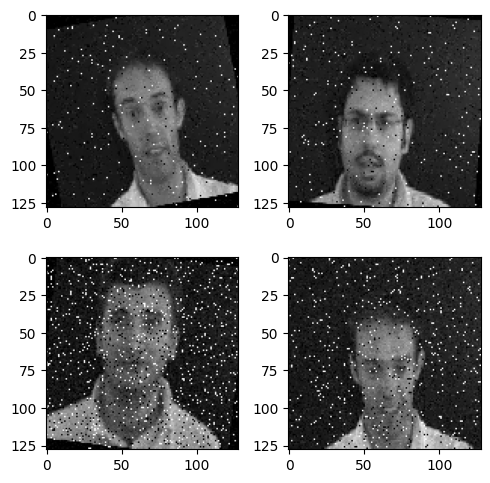

In [21]:
plotImages(sample_training_images[:4])

<a name="modeling"></a>
## MODELING

The training of this models in this work is pretty time-consuming. So for the presentation purposes of this notebook, I am skipping the trainings and instead loading those models from file.

Every training's code and output have been retained in this document. They are, respectively, commented-out and copied to the subsequent text cell.

#### Model 1 - A Borrowed CNN

The first CNN architecture that we tried out was this one that we borrowed from a Kaggler. The spirit of our borrowing was to simply get _any_ model trained successfully in our environment. Up until that point, we had been struggling somewhat despairingly with setting up the data.

##### **Create Model**

In [22]:
classifier = Sequential(name = 'M1.BorrowedCNN')

# Step 1 - Convolution
classifier.add(Conv2D(16, (3, 3), input_shape = (128, 128, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))

classifier.add(Dense(units = 6, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

classifier.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "M1.BorrowedCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,686,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,692,390 (14.09 MB)

 Trainable params: 3,692,390 (14.09 MB)

 Non-trainable params: 0 (0.00 B)

##### **Train Model**

As I mention at the top of this section (titled "MODELING") I have commented out the code that trains the model, in order to skip that time-consuming process. Instead, I load the model from file, in the "(Load model from file)" subsections.

The output/feedback of the training run can be found in the text cell just following the commented-out training code.

In [23]:
# train_time_start = time.time()

# history = classifier.fit(train_data_gen,
#                          epochs = 5,
#                          validation_data = val_data_gen)

# train_time_m1 = time.time() - train_time_start
# print(f"Training time: {train_time_m1} seconds")

The feedback of this now commented-out training:

```
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.1703 - loss: 2.3738 - val_accuracy: 0.1703 - val_loss: 1.7910
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.1812 - loss: 1.7901 - val_accuracy: 0.3057 - val_loss: 1.7598
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3135 - loss: 1.7114 - val_accuracy: 0.3740 - val_loss: 1.5551
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.4207 - loss: 1.4612 - val_accuracy: 0.4494 - val_loss: 1.4089
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.5141 - loss: 1.2483 - val_accuracy: 0.5213 - val_loss: 1.2438
Training time: 597.5946917533875 seconds
```



In [24]:
# saved_model_dirpath = '/content/drive/MyDrive/CSC_578/group_project/Saved keras models and histories/'

# classifier.save(f'{saved_model_dirpath}model_1.keras')
# pickle_to_file(history, f'{saved_model_dirpath}model_1_history.pickle')

##### **(Load model from file)**

Here I load this first model and its history from file.

In [25]:
saved_model_dirpath = '/content/drive/MyDrive/CSC_578/group_project/Saved keras models and histories/'

classifier = tf.keras.models.load_model(f'{saved_model_dirpath}model_1.keras')
history = unpickle_from_file(f'{saved_model_dirpath}model_1_history.pickle')

##### **Plot Accuracy and Loss**

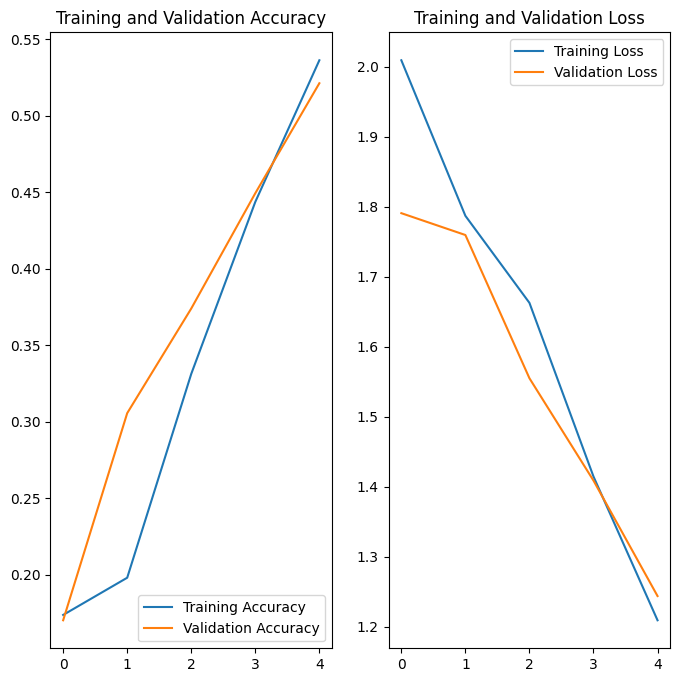

In [26]:
plot_history(history, 5)

##### Discussion

We can see from these plots that the accuracies were consistently rising and the loss had yet to plateau. If validation loss plateaus or otherwise diverges upwards from the training loss, it can indicate that adding more epochs to the training will not improve the model.

But that has not been indicated here. This model might likely benefit from more epochs. However, it tends to take at least 10 minutes to train as it is. I would instead like explore reducing this overlong training, before I refocus on optimizing for accuracy.

### RAISING BATCH SIZE

In an attempt to speed up the training, I here raise the batch size. I will also accordingly set the steps-per-epoch parameter for the three image data generators, which are those dedicated to training, validation, and testing.

In [27]:
BATCH_SIZE = 2048

In [28]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [29]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [30]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


Setting the eventual arguments for *steps-per-epoch*:

In [31]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
train_steps = int(train_steps)

val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
val_steps = int(val_steps)

test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)
test_steps = int(test_steps)

print(train_steps)
print(val_steps)
print(test_steps)

6
1
1


#### Model 2 - CNN from Project 6

Rather than build off the last model, which we borrowed from that Kaggle contributor, I start anew. For this second model, we adapt the architecture that was suggested in a prior homework assignment, Project #6.

##### **Create Model**

In [32]:
model_2 = Sequential(
    [
        Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
               input_shape=INPUT_SHAPE),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Flatten(),
        Dense(128, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(6, activation='softmax')
        ],

    name = 'M2.BatchSz2048xCNNp6'
    )

model_2.summary()

model_2.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M2.BatchSz2048xCNNp6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,065,270 (4.06 MB)

 Trainable params: 1,065,270 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

##### **Train Model**

In [33]:
# train_time_start = time.time()

# history_m2 = model_2.fit(train_data_gen,
#                          epochs = 5,
#                          validation_data = val_data_gen)

# train_time_m2 = time.time() - train_time_start
# print(f"Training time: {train_time_m2} seconds")

The above training was long and only done once, so it's feedback was copied here:

```
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 114s 17s/step - accuracy: 0.1745 - loss: 1.8049 - val_accuracy: 0.2296 - val_loss: 1.7811
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 134s 16s/step - accuracy: 0.2666 - loss: 1.7671 - val_accuracy: 0.3126 - val_loss: 1.7071
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 106s 17s/step - accuracy: 0.3227 - loss: 1.6817 - val_accuracy: 0.3391 - val_loss: 1.6277
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 105s 17s/step - accuracy: 0.3605 - loss: 1.5830 - val_accuracy: 0.3733 - val_loss: 1.5261
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 98s 17s/step - accuracy: 0.3821 - loss: 1.5068 - val_accuracy: 0.3573 - val_loss: 1.5229
Training time: 563.6926031112671 seconds
```



In [34]:
# model_2.save(f'{saved_model_dirpath}model_2.keras')
# pickle_to_file(history, f'{saved_model_dirpath}model_2_history.pickle')

##### **(Load model from file)**

For when training is skipped.

In [35]:
model_2 = tf.keras.models.load_model(f'{saved_model_dirpath}model_2.keras')
history_m2 = unpickle_from_file(f'{saved_model_dirpath}model_2_history.pickle')

##### **Plot Accuracy and Loss**

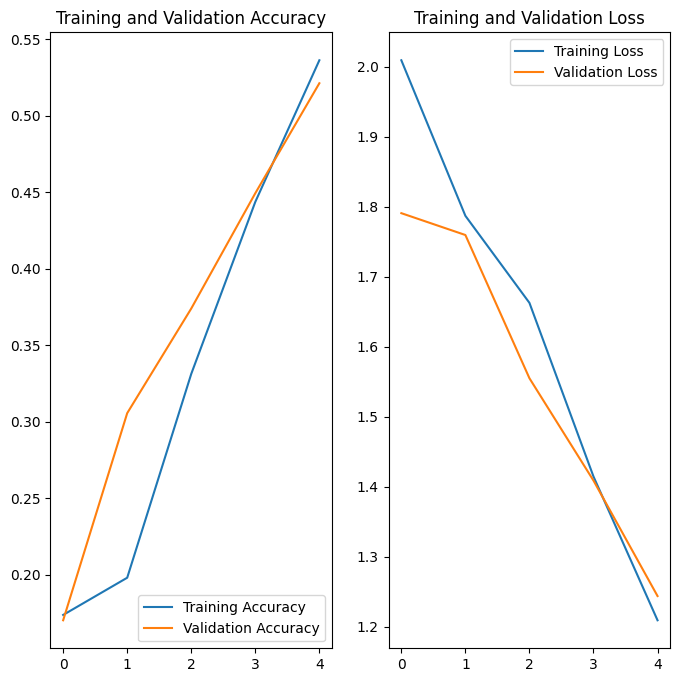

In [36]:
plot_history(history_m2, 5)

##### **Discussion**

Just as with the previous model, its plot suggests that more epochs might likely improve its general accuracy. There isn't yet an indication of overfitting.

Regarding runtimes, this model's is ~30 seconds less than the previous one. Between runtimes of 597 and 563, this represents a 5.7% reduction. Though meaningful, this reduction isn't as much as I was hoping for.

In the next section, to again attempt reducing the training times, I lower the image size in the generators.

### LOWERING IMAGE_SIZE

Lowering IMAGE_SIZE to 64 from 128. Counter to my effort to speed things up here, I'm also lowering BATCH_SIZE to 64, because raising it to ~2000 didn't seem to do much, anyway.

In [37]:
pixels = 64
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 64

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

In [38]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [39]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [40]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [41]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

In [42]:
print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [43]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
train_steps = int(train_steps)

val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
val_steps = int(val_steps)

test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)
test_steps = int(test_steps)

print(train_steps)
print(val_steps)
print(test_steps)

180
23
23


#### Visualizing Images

Now that we are using 64x64 instead of 128x128 images, it might be interesting to visualized a few randomly picked images from this lower-resolution training set we've created.

In [44]:
sample_training_images, _ = next(train_data_gen)

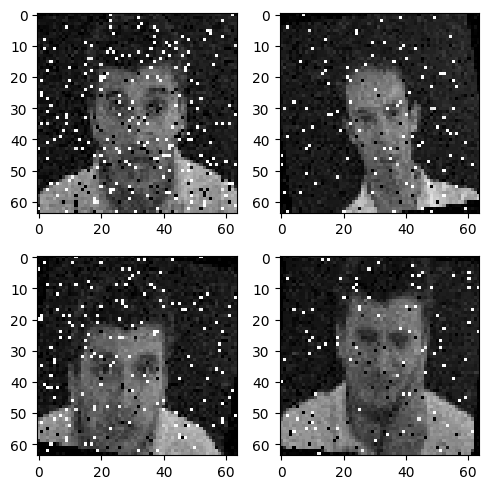

In [45]:
plotImages(sample_training_images[:4])

#### Model 3
Compared to preceding model (#2):
- Lowered image size
- Lowered batch size
- Same architecture, compilation, and training epochs.

##### Create Model

In [46]:
model_3 = Sequential(
    [
         Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
                input_shape=INPUT_SHAPE),
         MaxPooling2D(pool_size=(2, 2), strides=2),

         Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
         MaxPooling2D(pool_size=(2, 2), strides=2),

         Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
         MaxPooling2D(pool_size=(2, 2), strides=2),

         Flatten(),
         Dense(128, activation=tf.nn.relu),
         Dense(64, activation=tf.nn.relu),
         Dense(32, activation=tf.nn.relu),
         Dense(6, activation='softmax')
         ],

    name = 'M3.LowerImgSz',
    )

model_3.summary()

model_3.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M3.LowerImgSz"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,838 (1.06 MB)

 Trainable params: 278,838 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

##### **Train Model**

In [47]:
# train_time_start = time.time()

# history_m3 = model_3.fit(train_data_gen,
#                               epochs = 5,
#                               steps_per_epoch = train_steps,
#                               validation_data = val_data_gen)

# train_time_m3 = time.time() - train_time_start
# print(f"Training time: {train_time_m3} seconds")



```
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.2961 - loss: 1.6468 - val_accuracy: 0.5108 - val_loss: 1.2330
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.6004 - loss: 1.0075 - val_accuracy: 0.6895 - val_loss: 0.8181
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.7278 - loss: 0.7070 - val_accuracy: 0.7446 - val_loss: 0.6506
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.8164 - loss: 0.5125 - val_accuracy: 0.7955 - val_loss: 0.5647
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.8419 - loss: 0.4217 - val_accuracy: 0.8409 - val_loss: 0.4443
Training time: 196.8651828765869 seconds
```



In [48]:
# model_3.save(f'{saved_model_dirpath}model_3.keras')
# pickle_to_file(history_m3, f'{saved_model_dirpath}model_3_history.pickle')

##### **(Load model from file)**

In [49]:
model_3 = tf.keras.models.load_model(f'{saved_model_dirpath}model_3.keras')
history_m3 = unpickle_from_file(f'{saved_model_dirpath}model_3_history.pickle')

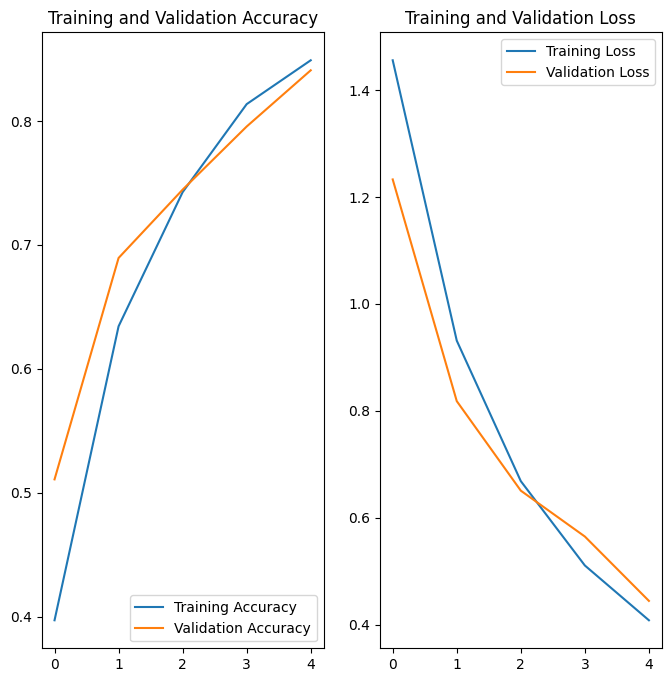

In [50]:
plot_history(history_m3, 5)

##### **Discussion**

This was successful in drastically reducing the training time. Approximately, it went from 9 minutes to 3. What's more, this model has the highest validation accuracy seen so far.

As with the two preceding models, the plot suggests that this model might likely benefit from the addition of epochs in training. I find such an addition much more welcome now, given the stark improvement in training time.

### RAISING BATCH SIZE AGAIN

Oops! In the previous section where I lowered the image size, I also opted to lowered the batch size back down, from 2048 to 64. I did this because I thought it was a trivial improvement, but maybe that was premature.

In [51]:
BATCH_SIZE = 2048

In [52]:
IMAGE_SIZE

(64, 64)

In [53]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [54]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [55]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [56]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
train_steps = int(train_steps)

val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
val_steps = int(val_steps)

test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)
test_steps = int(test_steps)

print(train_steps)
print(val_steps)
print(test_steps)

6
1
1


#### Model 4 - Low ImageSize, High BatchSize

##### Create Model

In [57]:
model_4 = Sequential(
    [
        Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
               input_shape=INPUT_SHAPE),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Flatten(),
        Dense(128, activation=tf.nn.relu),
        Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(6, activation='softmax')
        ],

    name = 'M4.LowImgSzHighBatch'
    )

model_4.summary()

model_4.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

Model: "M4.LowImgSzHighBatch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,838 (1.06 MB)

 Trainable params: 278,838 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

##### Train model

In [58]:
# train_time_start = time.time()

# history_m4 = model_4.fit(train_data_gen,
#                       steps_per_epoch = train_steps,
#                       epochs = 5,
#                       validation_data = val_data_gen,
#                       validation_steps=val_steps)

# train_time_m4 = time.time() - train_time_start
# print(f"Training time: {train_time_m4} seconds")

The above training was long and only done once, so it's feedback was copied here:

```
Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 7s/step - accuracy: 0.1861 - loss: 1.7922 - val_accuracy: 0.2254 - val_loss: 1.7659
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.2797 - loss: 1.7539 - val_accuracy: 0.3559 - val_loss: 1.7015
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.3500 - loss: 1.6770 - val_accuracy: 0.3468 - val_loss: 1.6164
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.3567 - loss: 1.5933 - val_accuracy: 0.3545 - val_loss: 1.5712
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.3828 - loss: 1.5271 - val_accuracy: 0.3992 - val_loss: 1.4768
Training time: 209.43036675453186 seconds
```



In [59]:
# model_4.save(f'{saved_model_dirpath}model_4.keras')
# pickle_to_file(history_m4, f'{saved_model_dirpath}model_4_history.pickle')

##### (Load model from file)

For when training is skipped.

In [60]:
model_4 = tf.keras.models.load_model(f'{saved_model_dirpath}model_4.keras')
history_m4 = unpickle_from_file(f'{saved_model_dirpath}model_4_history.pickle')

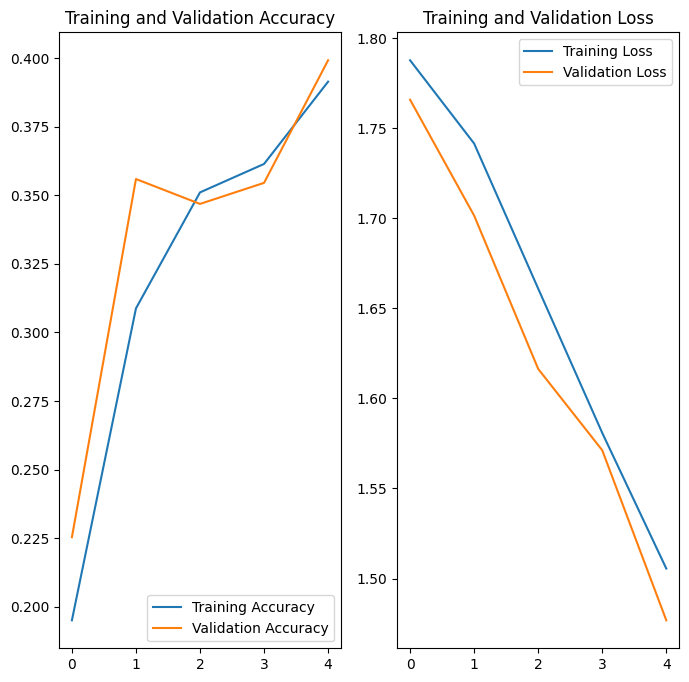

In [61]:
plot_history(history_m4, 5)

##### Discussion

This training took longer than the previous one, and was far less accurate. So before moving forward to hypertuning, I will here undo this section's batch size adjustments

#### Undoing this batch size adjustment


In [62]:
pixels = 64
IMAGE_SIZE = (pixels, pixels)
IMAGE_CHANNELS=3
BATCH_SIZE = 64

INPUT_SHAPE = (pixels, pixels, IMAGE_CHANNELS)

In [63]:
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 11475 images belonging to 6 classes.


In [64]:
val_data_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.


In [65]:
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.


In [66]:
TRAIN_SIZE = train_data_gen.samples
VAL_SIZE = val_data_gen.samples
TEST_SIZE = test_data_gen.samples

print(TRAIN_SIZE)
print(VAL_SIZE)
print(TEST_SIZE)

11475
1433
1438


In [67]:
train_steps = np.ceil(TRAIN_SIZE/BATCH_SIZE)
train_steps = int(train_steps)

val_steps = np.ceil(VAL_SIZE/BATCH_SIZE)
val_steps = int(val_steps)

test_steps = np.ceil(TEST_SIZE/BATCH_SIZE)
test_steps = int(test_steps)

print(train_steps)
print(val_steps)
print(test_steps)

180
23
23


<a name="hypertuning"></a>
## HYPERTUNING

Having settled on a batch size and an image size in the preceding modelling sections, I here start hypertuning.

The basic model that I am hypertuning strongly resembles models #2-4 from the preceding sections. But this hypertuning will try out different widths for the second and third hidden layers, as well as different learning rates for the Adam optimizer.

### Model 5 - Hypertuning our CNN

Hypertuning a CNN on our reduced-size images, since it performed best thereon.

#### **Create a subclass of HyperModel**

I create a subclass of `kt.Hypermodel` to pass to the Keras tuner.

In [68]:
class MyHyperModel(kt.HyperModel):
  def __init__(self, name):
    super().__init__(name=name)

  def build(self, hp):
    # Hypertuning widths of second and third dense layers
    hp_units_dl2 = hp.Int('units - l2', min_value=64, max_value=128, step=64)
    hp_units_dl3 = hp.Int('units - l3', min_value=32, max_value=64, step=32)

    # Hypertuning learning rate of Adam optimizer (in model compilation)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model = tf.keras.Sequential()

    model = Sequential(
        [
            Conv2D(8, (3,3), padding='same', activation=tf.nn.tanh,
                  input_shape=INPUT_SHAPE),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(16, (3,3), padding='same', activation=tf.nn.tanh),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Conv2D(32, (3,3), padding='same', activation=tf.nn.tanh),
            MaxPooling2D(pool_size=(2, 2), strides=2),

            Flatten(),
            Dense(128, activation=tf.nn.relu),
            Dense(units=hp_units_dl2, activation=tf.nn.relu),
            Dense(units=hp_units_dl3, activation=tf.nn.relu),
            Dense(6, activation='softmax')
            ],

        name = self.name
        )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

    return model

#### **Instantiate the tuner**

In [69]:
# Delete existing tuner dir (if needed)
%rm -rf ./Tuning_GroupProj/M5_Hypertuning

In [70]:
tuner = kt.Hyperband(MyHyperModel('M5.HypertunedM4Arch'),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='Tuning_GroupProj',
                     project_name='M5_Hypertuning')

Creating a callback for early stopping

In [71]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#### **Hypertune with tuner**

I am hypertuning for a couple hidden layers' widths and the Adams optimizer learning rate. Once these optimal parameters have been identified, I will print them below and then use them to train a new model, #5.

As a sidenote: I am adjusting the *steps-per-epoch* parameter for this hypertuning, despite the fact that our best run so far used its default setting. We are doing this because it would be prohibitively time-consuming to leave it as is.


In [72]:
# tuner.search(train_data_gen,
#              steps_per_epoch=train_steps,
#              validation_data=val_data_gen,
#              validation_steps=val_steps,
#              epochs=5,
#             #  epochs=1, # For testing, faster
#              callbacks=[stop_early])


# # Get the optimal hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

```
Trial 8 Complete [00h 01m 21s]
val_accuracy: 0.657362163066864

Best val_accuracy So Far: 0.7048150897026062
Total elapsed time: 00h 10m 45s
```

In [73]:
# print(f"""
# The hyperparameter search is complete. The optimal parameters of those tested are:

# Node count in 2nd hidden layer: {best_hps.get('units - l2')}
# Node count in 3rd hidden layer: {best_hps.get('units - l3')}
# Learning rate of Adam optimizer: {best_hps.get('learning_rate')}
# """)

```
The hyperparameter search is complete. The optimal parameters of those tested are:

Node count in 2nd hidden layer: 128
Node count in 3rd hidden layer: 32
Learning rate of Adam optimizer: 0.001
```

The parameters determined as the optimal ones in this hypertuning are similar to those we used for models #2-4.

The width of the third hidden layer and the Adam learning rate are the same as those of the prior models (`32` and `0.001`.)

But the width of the second hidden layer differs. The latter was previously `64` nodes, but `128` was instead found optimal here.

#### **Create and train model with optimal hyperparameters found**

In [74]:
# model_5 = MyHyperModel('M5.HypertunedM4Arch').build(best_hps)

# model_5.summary()

# history_m5 = model_5.fit(train_data_gen,
#                               steps_per_epoch=train_steps,
#                               validation_data=val_data_gen,
#                               validation_steps=val_steps,
#                               epochs=5)




```
Model: "M5.HypertunedM4Arch"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 289,142 (1.10 MB)
 Trainable params: 289,142 (1.10 MB)
 Non-trainable params: 0 (0.00 B)
Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 196ms/step - accuracy: 0.2562 - loss: 1.6901 - val_accuracy: 0.4815 - val_loss: 1.2647
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.5482 - loss: 1.1047 - val_accuracy: 0.6532 - val_loss: 0.9061
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.7124 - loss: 0.7538 - val_accuracy: 0.7313 - val_loss: 0.6874
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 202ms/step - accuracy: 0.8019 - loss: 0.5201 - val_accuracy: 0.7879 - val_loss: 0.5236
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.8490 - loss: 0.3973 - val_accuracy: 0.8207 - val_loss: 0.4458
```



In [75]:
# model_5.save(f'{saved_model_dirpath}model_5.keras')
# pickle_to_file(history_m5, f'{saved_model_dirpath}model_5_history.pickle')

#### **(Load model from file)**

In [76]:
model_5 = tf.keras.models.load_model(f'{saved_model_dirpath}model_5.keras')
history_m5 = unpickle_from_file(f'{saved_model_dirpath}model_5_history.pickle')

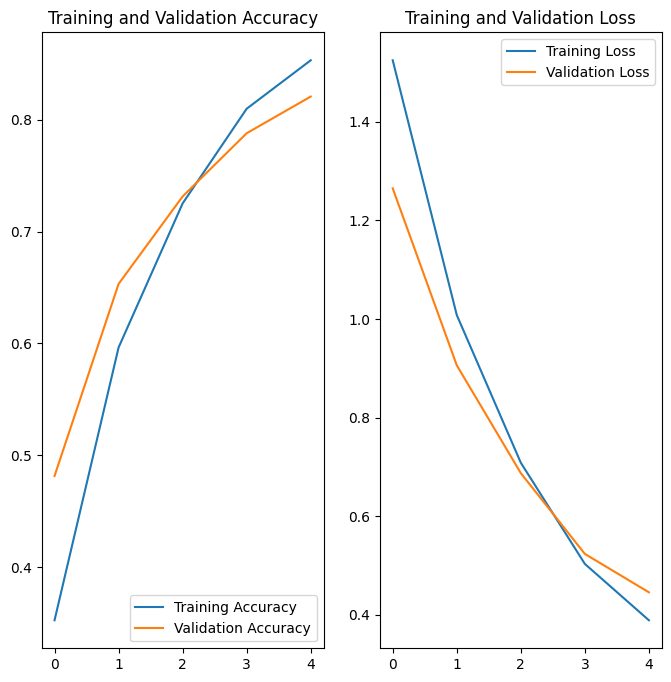

In [77]:
plot_history(history_m5, 5)

#### **Discussion**

By the validation results, the hypertuning looks to have yielded one of our best models yet, if not the best.

The above plot of its training and validation accuracies by epoch suggests that this model might well benefit from further epochs, as the validation loss curve has not yet plateaued.

In the next section, we follow this suggestion we've interpreted, by training the same architecture with more epochs.

### Model 6 - Adding Epochs

#### **Create and train model**

In [78]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [79]:
# model_6 = MyHyperModel('M6.RunMoreEpsOnM5').build(best_hps)
# model_6.summary()

# train_time_start = time.time()

# history_m6 = model_6.fit(train_data_gen,
#                          steps_per_epoch=train_steps,
#                          validation_data=val_data_gen,
#                          validation_steps=val_steps,
#                          epochs=15,
#                          callbacks=[stop_early])

# train_time_M6 = time.time() - train_time_start
# print(f"Training time: {train_time_M6} seconds")



```
Model: "M6.RunMoreEpsOnM5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 289,142 (1.10 MB)
 Trainable params: 289,142 (1.10 MB)
 Non-trainable params: 0 (0.00 B)
Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 39s 202ms/step - accuracy: 0.3007 - loss: 1.6423 - val_accuracy: 0.5429 - val_loss: 1.1509
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.5955 - loss: 0.9941 - val_accuracy: 0.6985 - val_loss: 0.7915
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 211ms/step - accuracy: 0.7382 - loss: 0.6924 - val_accuracy: 0.7739 - val_loss: 0.6267
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 38s 210ms/step - accuracy: 0.8181 - loss: 0.4873 - val_accuracy: 0.8151 - val_loss: 0.4850
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 42s 214ms/step - accuracy: 0.8689 - loss: 0.3572 - val_accuracy: 0.8423 - val_loss: 0.4078
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 0.8984 - loss: 0.2808 - val_accuracy: 0.8423 - val_loss: 0.4168
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.9165 - loss: 0.2354 - val_accuracy: 0.8660 - val_loss: 0.3794
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 191ms/step - accuracy: 0.9336 - loss: 0.1845 - val_accuracy: 0.8737 - val_loss: 0.3520
Epoch 9/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 171ms/step - accuracy: 0.9489 - loss: 0.1447 - val_accuracy: 0.8241 - val_loss: 0.4957
Epoch 10/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.9571 - loss: 0.1258 - val_accuracy: 0.8695 - val_loss: 0.3931
Epoch 11/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 32s 177ms/step - accuracy: 0.9618 - loss: 0.1087 - val_accuracy: 0.8569 - val_loss: 0.4111
Training time: 415.0024993419647 seconds
```



In [80]:
# model_6.save(f'{saved_model_dirpath}model_6.keras')
# pickle_to_file(history_m6, f'{saved_model_dirpath}model_6_history.pickle')

#### **(Load model from file)**

In [81]:
model_6 = tf.keras.models.load_model(f'{saved_model_dirpath}model_6.keras')
history_m6 = unpickle_from_file(f'{saved_model_dirpath}model_6_history.pickle')

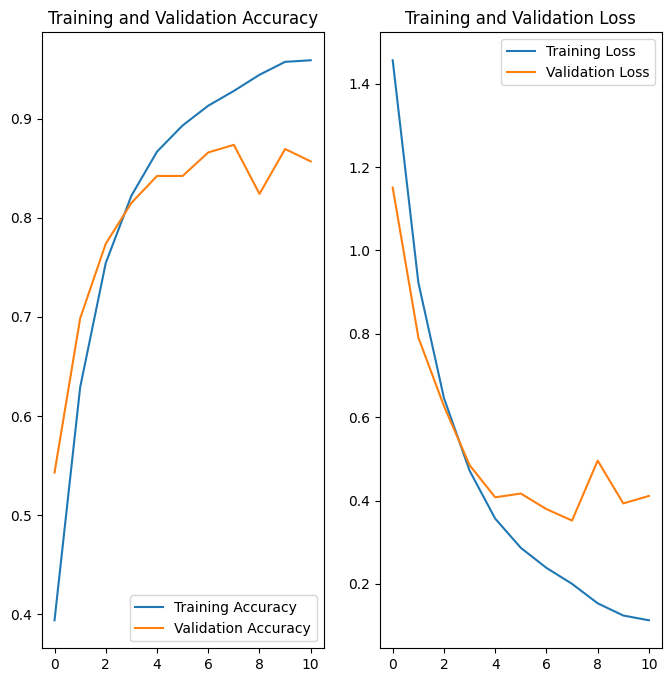

In [82]:
plot_history(history_m6, 11)

#### **Discussion**

The graph above clearly indicates substantial overfitting, taking place after epoch #7. Given this, I wonder if it might perform similarly to the previous model, 'M5', which was the same as this one except trained for just 5 epochs.

## BATCH NORMALIZATION

Here we try out a CNN that utilizes both dropout layers and batch normalization. Perhaps the resulting model might be less overfit than the last (the 11-epoch model #6).

### Model 7

#### **Create model**

In [83]:
model_7 = Sequential(name = 'M7.1stBatchNorm')

model_7.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(3, 3)))
model_7.add(Dropout(0.15))

model_7.add(Conv2D(64, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2, 2)))
model_7.add(Dropout(0.15))

model_7.add(Conv2D(128, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(3, 3)))
model_7.add(Dropout(0.15))

model_7.add(Flatten())
model_7.add(Dense(128, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dense(64, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dense(32, activation='relu'))
model_7.add(BatchNormalization())
model_7.add(Dropout(0.15))
model_7.add(Dense(6, activation='softmax'))

model_7.summary()

model_7.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "M7.1stBatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             1

 Total params: 171,238 (668.90 KB)

 Trainable params: 170,342 (665.40 KB)

 Non-trainable params: 896 (3.50 KB)

#### **Train model**

In [84]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_time_start = time.time()

# history_m7 = model_7.fit(
#     train_data_gen,
#     steps_per_epoch=train_steps,
#     epochs=15,
#     validation_data=val_data_gen,
#     validation_steps=val_steps,
#     callbacks=[stop_early]
# )

# train_time_m7 = time.time() - train_time_start
# print(f"Training time: {train_time_m7} seconds")



```
Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 66s 337ms/step - accuracy: 0.1911 - loss: 2.1004 - val_accuracy: 0.2031 - val_loss: 2.1332
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 88s 372ms/step - accuracy: 0.3203 - loss: 1.6512 - val_accuracy: 0.2254 - val_loss: 2.2991
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 366ms/step - accuracy: 0.4305 - loss: 1.4206 - val_accuracy: 0.3524 - val_loss: 1.9120
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 371ms/step - accuracy: 0.5117 - loss: 1.2231 - val_accuracy: 0.4027 - val_loss: 1.5374
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 357ms/step - accuracy: 0.5777 - loss: 1.1003 - val_accuracy: 0.5555 - val_loss: 1.1511
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 73s 308ms/step - accuracy: 0.6250 - loss: 0.9739 - val_accuracy: 0.5869 - val_loss: 1.0413
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 303ms/step - accuracy: 0.6561 - loss: 0.8844 - val_accuracy: 0.6643 - val_loss: 0.8420
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.6876 - loss: 0.8283 - val_accuracy: 0.6546 - val_loss: 0.8903
Epoch 9/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.7048 - loss: 0.7691 - val_accuracy: 0.7299 - val_loss: 0.6616
Epoch 10/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 54s 301ms/step - accuracy: 0.7331 - loss: 0.7010 - val_accuracy: 0.7718 - val_loss: 0.6217
Epoch 11/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.7542 - loss: 0.6555 - val_accuracy: 0.6301 - val_loss: 0.9173
Epoch 12/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 285ms/step - accuracy: 0.7603 - loss: 0.6310 - val_accuracy: 0.7879 - val_loss: 0.5167
Epoch 13/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 85s 304ms/step - accuracy: 0.7856 - loss: 0.5759 - val_accuracy: 0.6308 - val_loss: 0.9892
Epoch 14/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 61s 339ms/step - accuracy: 0.8013 - loss: 0.5247 - val_accuracy: 0.7948 - val_loss: 0.5317
Epoch 15/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 66s 365ms/step - accuracy: 0.8135 - loss: 0.5028 - val_accuracy: 0.8067 - val_loss: 0.5386
Training time: 1081.3128955364227 seconds
```



In [85]:
# model_7.save(f'{saved_model_dirpath}model_7.keras')
# pickle_to_file(history_m7, f'{saved_model_dirpath}model_7_history.pickle')

#### **(Load model from file)**

In [86]:
model_7 = tf.keras.models.load_model(f'{saved_model_dirpath}model_7.keras')
history_m7 = unpickle_from_file(f'{saved_model_dirpath}model_7_history.pickle')

In [87]:
val_loss, val_acc = model_7.evaluate(val_data_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.8375 - loss: 0.4791


In [88]:
train_loss, train_acc = model_7.evaluate(train_data_gen)

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 203ms/step - accuracy: 0.8537 - loss: 0.3977


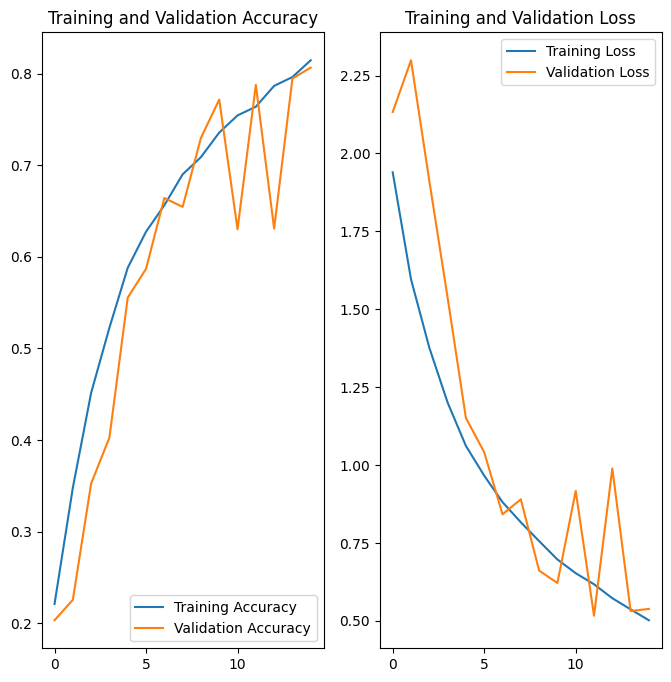

In [89]:
plot_history(history_m7, 15)

#### **Discussion**

This model could have benefitted from more epochs in training, judging by these plots. When I specified 15 epochs for training, I expected that would be enough, but I was mistaken.

I am tempted to immediately rerun this with more epochs, but this was already 20 minutes spent. I will instead move forward, but maybe return for additional training if I have time.

### Model 8

#### **Create model**

In [90]:
model_8 = Sequential(name = 'M8.2ndBatchNorm')

model_8.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(3, 3)))
model_8.add(Dropout(0.15))

model_8.add(Conv2D(64, (3, 3), activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2, 2)))
model_8.add(Dropout(0.15))

model_8.add(Conv2D(128, (3, 3), activation='relu'))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(3, 3)))
model_8.add(Dropout(0.15))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(BatchNormalization())
model_8.add(Dropout(0.15))
model_8.add(Dense(6, activation='softmax'))

model_8.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

model_8.summary()

Model: "M8.2ndBatchNorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 9, 9, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 127,622 (498.52 KB)

 Trainable params: 127,046 (496.27 KB)

 Non-trainable params: 576 (2.25 KB)

#### **Train model**

In [91]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_time_start = time.time()

# history_m8 = model_8.fit(
#     train_data_gen,
#     steps_per_epoch=train_steps,
#     epochs=15,
#     validation_data=val_data_gen,
#     validation_steps=val_steps,
#     callbacks=[stop_early]
# )

# train_time_M8 = time.time() - train_time_start
# print(f"Training time: {train_time_M8} seconds")



```
Epoch 1/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 57s 300ms/step - accuracy: 0.2123 - loss: 2.0155 - val_accuracy: 0.1605 - val_loss: 2.1576
Epoch 2/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 308ms/step - accuracy: 0.3550 - loss: 1.5854 - val_accuracy: 0.2484 - val_loss: 1.7726
Epoch 3/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.4529 - loss: 1.3624 - val_accuracy: 0.3608 - val_loss: 1.5790
Epoch 4/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 58s 322ms/step - accuracy: 0.5335 - loss: 1.1751 - val_accuracy: 0.5136 - val_loss: 1.2385
Epoch 5/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 56s 310ms/step - accuracy: 0.5927 - loss: 1.0469 - val_accuracy: 0.6622 - val_loss: 0.9158
Epoch 6/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 64s 355ms/step - accuracy: 0.6318 - loss: 0.9586 - val_accuracy: 0.5792 - val_loss: 1.1165
Epoch 7/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 366ms/step - accuracy: 0.6509 - loss: 0.8898 - val_accuracy: 0.6678 - val_loss: 0.8960
Epoch 8/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 79s 350ms/step - accuracy: 0.6930 - loss: 0.8152 - val_accuracy: 0.5967 - val_loss: 1.0685
Epoch 9/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 63s 351ms/step - accuracy: 0.6981 - loss: 0.7693 - val_accuracy: 0.7683 - val_loss: 0.6702
Epoch 10/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 64s 354ms/step - accuracy: 0.7198 - loss: 0.7326 - val_accuracy: 0.7648 - val_loss: 0.6366
Epoch 11/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 65s 364ms/step - accuracy: 0.7429 - loss: 0.6678 - val_accuracy: 0.6197 - val_loss: 1.0278
Epoch 12/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 81s 359ms/step - accuracy: 0.7786 - loss: 0.6045 - val_accuracy: 0.7906 - val_loss: 0.5790
Epoch 13/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 86s 381ms/step - accuracy: 0.7829 - loss: 0.5700 - val_accuracy: 0.8018 - val_loss: 0.5339
Epoch 14/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 69s 383ms/step - accuracy: 0.7964 - loss: 0.5473 - val_accuracy: 0.8179 - val_loss: 0.4856
Epoch 15/15
180/180 ━━━━━━━━━━━━━━━━━━━━ 78s 360ms/step - accuracy: 0.8053 - loss: 0.5227 - val_accuracy: 0.8227 - val_loss: 0.4770
Training time: 1045.7733359336853 seconds
```



In [92]:
# model_8.save(f'{saved_model_dirpath}model_8.keras')
# pickle_to_file(history_m8, f'{saved_model_dirpath}model_8_history.pickle')

#### **(Load model from file)**

In [93]:
model_8 = tf.keras.models.load_model(f'{saved_model_dirpath}model_8.keras')
history_m8 = unpickle_from_file(f'{saved_model_dirpath}model_8_history.pickle')

In [94]:
val_loss, val_acc = model_8.evaluate(val_data_gen)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - accuracy: 0.8446 - loss: 0.4182


In [95]:
train_loss, train_acc = model_8.evaluate(train_data_gen)

180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step - accuracy: 0.8924 - loss: 0.3134


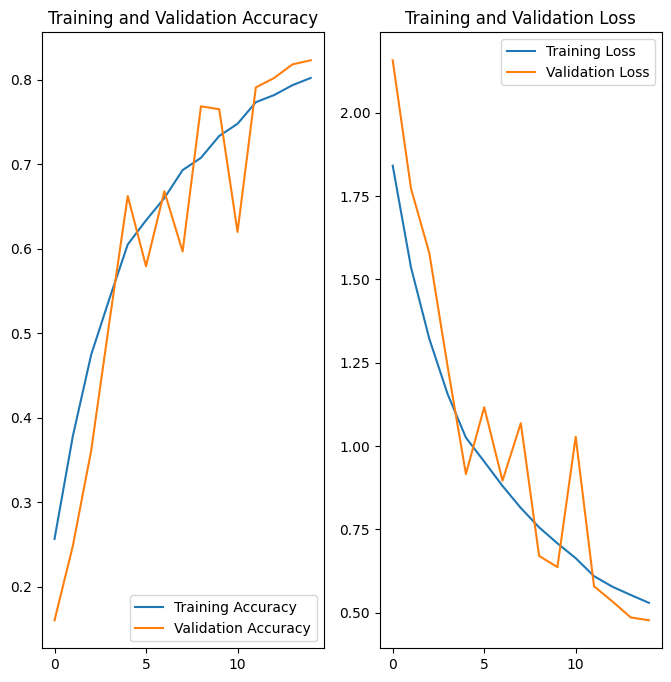

In [96]:
plot_history(history_m8, 15)

#### **Discussion**

Like the previous model, this one probably could have benefitted from more epochs in training. But at 15 epochs, this training was already as long as 17 minutes.

<a name="evaluating-models"></a>
## EVALUATING MODELS

To evaluate the models, against both the validation and test sets, I create tables to log their results.

I define a method `eval_performance` that I will call iteratively to evaluate each model and output its result data in a row (or `list()`) for that table.

<a name="validation"></a>
### VALIDATION

##### Create table for validation results

In [97]:
val_results = pd.DataFrame({'model':[],
                           'val_accuracy':[],
                           'val_f1':[],
                           'val_recall':[],
                           'val_precision':[]
                           })
val_results.T

""
model
val_accuracy
val_f1
val_recall
val_precision


##### **eval_performance** function

In [98]:
def eval_performance(val_data, model, record=False, ConfMatrix=True):
  ''' Validates model on given set (generator) and plots confusion matrix. '''
  VAL_SIZE = val_data.samples
  BATCH_SIZE = val_data.batch_size
  steps = np.ceil(VAL_SIZE/BATCH_SIZE)
  steps = int(steps)

  val_pred_probas = model.predict(val_data, steps=steps)
  val_preds = np.argmax(val_pred_probas, axis=1)
  conf_matrix = confusion_matrix(val_data.classes, val_preds)

  target_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness']


  if ConfMatrix:
    print('\n\n', classification_report(val_data.classes, val_preds,
                                      target_names=target_names))

    plot_confusion_matrix_heatmap(conf_matrix, target_names)

  if record:


    # Make classification report dictionary to  get f1, recall, and precision
    val_class_dict = classification_report(val_data.classes, val_preds,
                                          target_names=target_names,
                                          output_dict=True, zero_division=0)

    val_acc = val_class_dict['accuracy']
    val_w_avg_f1 = val_class_dict['weighted avg']['f1-score']
    val_w_avg_recall = val_class_dict['weighted avg']['recall']
    val_w_avg_precision = val_class_dict['weighted avg']['precision']



    return [model.name, val_acc, val_w_avg_f1, val_w_avg_recall,
            val_w_avg_precision]

#### Recreating generators that correspond to each model

In [99]:
model_1_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=256,
    class_mode='categorical',
    shuffle=False
)

model_2_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(128, 128),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

model_4_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(64, 64),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

else_val_gen = validation_image_generator.flow_from_directory(
    validate_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.
Found 1433 images belonging to 6 classes.


#### Evaluating models and logging results

In [100]:
print(os.listdir(saved_model_dirpath))

['model_1_history.pickle', 'model_1.keras', 'model_2.keras', 'model_2_history.pickle', 'model_3.keras', 'model_3_history.pickle', 'model_4.keras', 'model_4_history.pickle', 'model_5.keras', 'model_5_history.pickle', 'model_6.keras', 'model_6_history.pickle', 'model_7_history.pickle', 'model_7.keras', 'model_8.keras', 'model_8_history.pickle', '.ipynb_checkpoints']


In [101]:
for i, filename in enumerate(os.listdir(saved_model_dirpath)):
  if filename.endswith('.keras'):
    print(filename)

model_1.keras
model_2.keras
model_3.keras
model_4.keras
model_5.keras
model_6.keras
model_7.keras
model_8.keras


In [102]:
for i, filename in enumerate(os.listdir(saved_model_dirpath)):
  if filename.endswith('.keras'):
    the_val_gen = None
    print(filename)
    match filename:
      case 'model_1.keras':
        the_val_gen = model_1_val_gen
      case 'model_2.keras':
        the_val_gen = model_2_val_gen
      case 'model_4.keras':
        the_val_gen = model_4_val_gen
      case _:
        the_val_gen = else_val_gen

    model = tf.keras.models.load_model(saved_model_dirpath + filename)
    val_results.loc[i] = eval_performance(the_val_gen, model, record=True,
                                          ConfMatrix=False)
# print('\n\n')
# val_results

model_1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
model_2.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
model_3.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step
model_4.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
model_5.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step
model_6.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step
model_7.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step
model_8.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step


In [103]:
val_results.sort_values('val_accuracy', ascending=False)

,model,val_accuracy,val_f1,val_recall,val_precision
10,M6.RunMoreEpsOnM5,0.856943,0.858140,0.856943,0.863957
4,M3.LowerImgSz,0.840893,0.839687,0.840893,0.844542
14,M8.2ndBatchNorm,0.822749,0.819458,0.822749,0.827611
8,M5.HypertunedM4Arch,0.820656,0.821305,0.820656,0.824942
13,M7.1stBatchNorm,0.806699,0.808138,0.806699,0.813481
1,M1.BorrowedCNN,0.521284,0.511070,0.521284,0.558824
6,M4.LowImgSzHighBatch,0.399163,0.394401,0.399163,0.398953
2,M2.BatchSz2048xCNNp6,0.357292,0.328361,0.357292,0.395272


#### **Discussion**

In validation, our sixth model, 'M6.HpWithMoreEps,' was our most accurate, but by a narrow advantage of `0.017`. I am not especially surprised that it is the top performer, given that this model is the culmination of several of this project's central adjustments, including:
1. It is trained off the lower-resolution images which were found to improve both runtime and accuracy convergence, seemingly.
2. It uses the parameters that were identified as optimal in the hypertuning that led to model "M5.Hypertuned."
3. It was trained with more epochs than "M5", as well as most models here (11 after early stopping.) Most of the models might've benefitted similarly from so many added epochs, judging by their history plots.

There were several other models that also showed validation accuracies higher than `0.8`. There were also three models that performed poorly in comparison, with validation accuracies less than `0.53`.

<a name="test"></a>
### TEST

##### Create table for validation results

In [104]:
test_results = pd.DataFrame({'model':[],
                           'test_accuracy':[],
                           'test_f1':[],
                           'test_recall':[],
                           'test_precision':[]
                           })
test_results.T

""
model
test_accuracy
test_f1
test_recall
test_precision


#### Recreating test generators

In [105]:
model_1_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=256,
    class_mode='categorical',
    shuffle=False
)

model_2_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

model_4_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=2048,
    class_mode='categorical',
    shuffle=False
)

else_test_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.
Found 1438 images belonging to 6 classes.


#### Evaluating models and logging results

In [106]:
for i, filename in enumerate(os.listdir(saved_model_dirpath)):
  if filename.endswith('.keras'):
    the_test_gen = None
    match filename:
      case 'model_1.keras':
        the_test_gen = model_1_test_gen
      case 'model_2.keras':
        the_test_gen = model_2_test_gen
      case 'model_4.keras':
        the_test_gen = model_4_test_gen
      case _:
        the_test_gen = else_test_gen

    model = tf.keras.models.load_model(saved_model_dirpath + filename)
    test_results.loc[i] = eval_performance(the_test_gen, model, record=True,
                                          ConfMatrix=False)
# print('\n\n')
# test_results

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step


In [107]:
test_results.sort_values('test_accuracy', ascending=False)

,model,test_accuracy,test_f1,test_recall,test_precision
10,M6.RunMoreEpsOnM5,0.872045,0.871795,0.872045,0.876146
8,M5.HypertunedM4Arch,0.844924,0.844932,0.844924,0.848210
4,M3.LowerImgSz,0.836579,0.836216,0.836579,0.839501
14,M8.2ndBatchNorm,0.836579,0.833701,0.836579,0.840881
13,M7.1stBatchNorm,0.816412,0.817784,0.816412,0.824308
1,M1.BorrowedCNN,0.510431,0.496537,0.510431,0.548119
6,M4.LowImgSzHighBatch,0.383866,0.377734,0.383866,0.384189
2,M2.BatchSz2048xCNNp6,0.326147,0.295435,0.326147,0.354162


In [108]:
val_results.sort_values('val_accuracy', ascending=False)

,model,val_accuracy,val_f1,val_recall,val_precision
10,M6.RunMoreEpsOnM5,0.856943,0.858140,0.856943,0.863957
4,M3.LowerImgSz,0.840893,0.839687,0.840893,0.844542
14,M8.2ndBatchNorm,0.822749,0.819458,0.822749,0.827611
8,M5.HypertunedM4Arch,0.820656,0.821305,0.820656,0.824942
13,M7.1stBatchNorm,0.806699,0.808138,0.806699,0.813481
1,M1.BorrowedCNN,0.521284,0.511070,0.521284,0.558824
6,M4.LowImgSzHighBatch,0.399163,0.394401,0.399163,0.398953
2,M2.BatchSz2048xCNNp6,0.357292,0.328361,0.357292,0.395272


#### **Discussion**

The optimally accurate model of this bunch was Model #6, which was the hypertuned model trained with more epochs. It shows a test accuracy of `0.872`. In validation, it enjoyed a slight accuracy advantage of `0.017` over its nearest competitor, a lead that widened in test to `0.028`.

The group of four models that were just behind 'M6' in validation are the same group of neighbors in the test results, but those neighbors' positions within that group have changed. The first model from the 'BATCH NORMALIZATION' section ('M7.1stBatchNorm') is now the top-performing of this group. It is more accurate than its section-mate 'M8' by `0.018`.


## EXAMINING THE BEST MODEL'S PREDICTIONS

To strengthen my sense of the optimal classifier and its error, I examine its confusion matrix of its test performance.

<a name="confusion-matrix"></a>
### CONFUSION MATRIX

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step


               precision    recall  f1-score   support

       Anger       0.97      0.95      0.96       237
     Disgust       0.84      0.89      0.87       237
        Fear       0.87      0.77      0.82       241
   Happiness       0.80      0.93      0.86       241
     Neutral       0.92      0.80      0.86       241
     Sadness       0.85      0.90      0.87       241

    accuracy                           0.87      1438
   macro avg       0.88      0.87      0.87      1438
weighted avg       0.88      0.87      0.87      1438



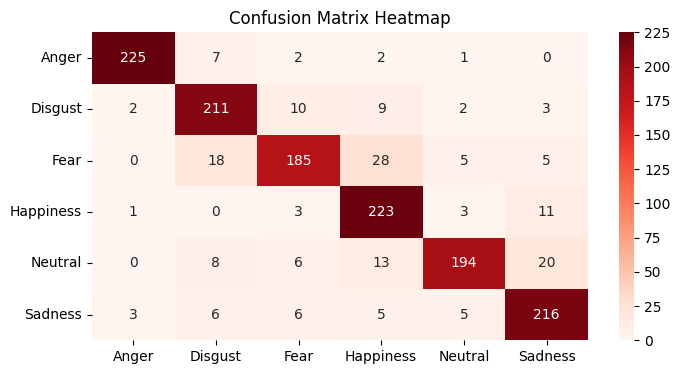

In [109]:
best_model = tf.keras.models.load_model(f'{saved_model_dirpath}model_6.keras')
eval_performance(else_test_gen, best_model)

Judging by this confusion matrix, a few of the most common misclassifications were the following:

- *Fear* misclassified as *Happiness*.
- *Fear* misclassified as *Disgust*.
- *Neutral* misclassified as *Sadness*.

Fear was the emotion that this classifier struggled with the most, as it was the most commonly misclassified. The second-most misclassified was the neutral emotion, which was often mistaken for sadness or happiness.

Overall, the most commonly misclassified emotions were *Fear* and *Neutral*, which had `56` and `47` false negatives, respectively. Accordingly, they showed the lowest recall scores.

The most commonly misattributed emotions were *Happiness*, *Sadness*, and *Disgust*, which had `57`, `39`, and `39` false positives, respectively. Accordingly, these showed the lowest precision scores.

Speculating on misattributions:
- Might fear get confused for happiness because the emotions share excitement? Might both emotions be facially expressed with wide eyes?

- Might fear and disgust get confused for each other because the emotions share repulsion? Might both emotions be facially expressed with frowns?

- Might neutral and sadness get confused for each other because the emotions are both low-energy? Might both emotions be facially expressed pretty blankly?

<br></br>
<br></br>
<a name="conclusions"></a>
## CONCLUSIONS

This being a classification task that was thin on exploration, my conclusions primarily relate to my recalibrations in the iterative modelling process:

- **Lowering the image size was beneficial, much more than raising batch size.** It benefitted both the runtimes and the accuracies of my models. Surprisingly, raising the batch size only marginally decreased my runtimes, and with considerable cost to accuracy.

- **Adding regularization was beneficial.** The models that had such additions, which here were the DropOut and BatchNormalization layers, appeared to have greatly benefitted therefrom.

- **Widening the second layer was beneficial.** Hypertuning helped us to arrive at this choice. This benefit is consistent with that which Max encountered in the Project #6 assignment. So in future neural network projects, he might first consider widening the second layers.

- ***Fear* and *Neutral* were the most commonly misclassified emotions (by our optimally accurate classifier.)** These are emotions that might be primarily characterized by their energy level, where fear is high-energy and neutral is low. Are these extreme energies generally difficult to classify in images?
  - How does *Anger* complicate this speculation- it was the most effectively classified emotion, but is it not also "high-energy"?

<br></br>

<!-- The main findings:
  - Lowering the image size to 64x64 rather than our initial setting of 128x128 not only helped the runtimes considerably, but also consistently resulted in more accurate models.
    - As a side note, our efforts to improve runtimes by raising the batch size were mostly in vain: these only ever resulted in  marginal decreases in runtime and they also typically costed the accuracy considerably. (This was the case for our model named 'M4.LowImgSzHighBatch'.)

  -  Regularization measures like DropOut layers and BatchNormalization layers appear to have greatly benefitted the models where we implemented them. Our model 'M7.1stBatchNorm' was our second-best in test accuracy. Just as a well-regularized model might, its validation accuracy wasn't the flashiest of the bunch, but this model was flashy where it mattered most, in its test performance.

  - Some hypertuning efforts determined that it was beneficial to add width to the second hidden layer (of four in that model) while keeping the third and the Adam learning rate consistent. This was a similar optimal scenario to what Max found in his homework for Project 6, so he might look first to widening such second layers in similar future projects. -->

<a name="future-work"></a>
## FUTURE WORK

Some things we would try if we had more time:

- **Add regularization to our best model.** If time afforded it, we would like to have improved the accuracy of our best model by adding in layers `DropOut` and `BatchNormalization`.

- **Add 5-10 epochs of training.** We might add more epochs to train the several models that looked like they would benefit from it.

- **Visualize some misclassified sample images.** To further hone in on the nature of our optimal classifier's error, we would visualize some sample images that were misclassified.

- **Reduce image size further.** We would try an even smaller image size, to gain a sense of where the line is: how few pixels is too costly when it comes to interpreting emotions from facial expressions?

- **Incorporate our grayscaled image work.** In a separate Colab notebook, we successfully used grayscaled versions of these images to train and test models. Unfortunately, we were unable to merge that work into this notebook before the deadline.

<br></br>
<a name="challenges-faced"></a>
## CHALLENGES FACED: `ImageDataGenerator`

This was our first time using the `ImageDataGenerator` outside of the guided homework assignment. We might owe the following challenges to that inexperience of ours:

- **Data setup and loading into generators**:

  We experienced some struggle in setting up the large data files in a shared Google Drive, such that we could all load from there. There was an issue of corrupted data at one point. Perhaps more notably, this setup was our first time loading our own image data generators in a way where they 'flow from directories.'

- **Starting with too high an image size, for that `ImageDataGenerator` setting**:

  For the image size, we initially set it at 128, as these images were often 400 x 400 and we wanted to take advantage of that resolution. However, given that the training set contains as many as 11,000+ samples, we needed to drastically reduce that image size to 64, to cut training times down from 15 minutes to 6 or less.

- **Extracting labels from the generators:**

  Figuring out how to get the labels from our image data generator was difficult. The structure in our case was different than those from our class examples, seemingly.

- **Unawareness of the *shuffle* parameter setting complicated evaluation**

  Another challenge was realizing that the default setting for the ImageDataGenerator's *shuffle* parameter is **True**. This was highly consequential for evaluation executed outside of the `model.fit()` function. Evaluation done within the `model.fit()` behavior was somehow unaffected by a discrepancy of *shuffle* settings between our train and val generator

<br></br>
